# Mapas interactivos fauna en Córdoba

# se carga las librerías necesarias y la base de datos

In [ ]:
import pandas as pd
import os
DATA_DIR = 'data' 
records= pd.read_csv(os.path.join(DATA_DIR,'dataset_CSsources.csv'))
cameras = pd.read_csv(os.path.join(DATA_DIR, 'locCam3.csv'), sep=';') #ojo con el separador
cameras.columns = cameras.columns.str.strip()  # Elimina espacios no es necesario pero por si acaso




[False False False False False False False False False False False False
 False False False False False False False False]
             spp              sp  Grid  Platform  Records
0    O_cuniculus    O. cuniculus  UG18      GBIF        5
1    O_cuniculus    O. cuniculus  UG18     NoVal       34
2    O_cuniculus    O. cuniculus  UG18    seqRec      129
3    O_cuniculus    O. cuniculus  UG18  dailyRec       48
4  L_granatensis  L. granatensis  UG18      GBIF        0


In [ ]:
print(cameras.columns.duplicated()) # para verificar si hay columnas duplicadas
print (records.head())
print (cameras.head())

   field_1    Nombre.Loc  Latitude  Longitude  Deer  Weasel  Marten  Genet  \
0        1     24-TRE-C1     37.94     -4.850     0       0       0      0   
1        6     24-TRE-C2     37.93     -4.849     0       0       0      0   
2        8  24_ALQU_C1_1     37.69     -4.882     0       0       0      0   
3        9  24_ALQU_C1_2     37.69     -4.883     0       0       0      0   
4       10  24_ALQU_C1_3     37.69     -4.882     0       0       0      0   

   Wild.Boar  Rabbit  Hare  Dormouse  Moongoose  Shrew  Otter  Rat  Mouses  \
0          2       0     0         0          0      0      0    0       0   
1          2       0     0         0          0      0      0    0       0   
2          0       1     0         0          1      0      0    0       0   
3          0       5     0         0          0      0      0    0       0   
4          0      55     0         0          3      0      0    0       0   

   Badger  Fox  Total.gene  
0       0    0           2  
1   

In [ ]:
# Se cargan las bases de datos complementarias en shp
import geopandas as gpd
# Cargar el archivo SHP
gbif_df = gpd.read_file(os.path.join(DATA_DIR,"GBIFdata_CO.shp"))
CO_UTM_df = gpd.read_file(os.path.join(DATA_DIR,"CO_UTM2.shp")) 
# Mostrar las primeras filas
print(gbif_df.head())
print(CO_UTM_df.head())
print("CRS de GBIF:", gbif_df.crs)
print("CRS de CO_UTM:", CO_UTM_df.crs)


#Si necesitas transformar ambos al mismo CRS 
gbif_df_3857 = gbif_df.to_crs("EPSG:3857")
CO_UTM_df_3857 = CO_UTM_df.to_crs("EPSG:3857")
# niveles de una columna específica
print(gbif_df.columns)
print(gbif_df["institut_1"].unique())  # ver niveles nombre  de la columna



In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Paso 1: Eliminar filas con coordenadas nulas (si las hay)

cameras_points = gpd.GeoDataFrame(
    cameras,
    geometry= [Point (xy) for xy in zip(cameras['Longitude'], cameras['Latitude'])],
    crs="EPSG:4326")
print(cameras_points.head())

In [ ]:
# reproyección de las cámaras a EPSG:3857
cameras_3857 = cameras_points.to_crs(epsg=3857)
cameras_3857.head()

In [ ]:
# Mapa básico con geopandas estático
import matplotlib.pyplot as plt
import contextily as ctx
ax = cameras_points.plot(figsize=(6,6), markersize=50)
ax.set_title("camera locations")

# Fondo de mapa de contexto
ax = cameras_3857.plot(figsize=(6,6), markersize=40)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
#plt.show ()

## Mapas interactivos con Plotly Express

In [ ]:
import plotly.express as px

fig = px.scatter_geo(
    cameras,
     lat='Latitude',
     lon='Longitude', 
     hover_name='Nombre.Loc',
     hover_data={'Wild.Boar':True, 'Deer':True, 'Fox':True, 'Latitude':False, 'Longitude':False},
     size='Total.gene', projection='natural earth',
     title= 'Camera Locations with Animal Sightings',
     scope='europe')
fig.update_geos(
    center={"lat": 40.0, "lon": -3.7},
    fitbounds="locations"
)
# fig.show()

In [ ]:
#Mapa Burbujas con rejilla
import plotly.express as px

fig = px.scatter_mapbox(
    cameras,
    lat='Latitude',
    lon='Longitude',
    hover_name='Nombre.Loc',
    hover_data={
        'Wild.Boar': True,
        'Deer': True,
        'Fox': True,
        'Latitude': False,
        'Longitude': False
    },
    size='Total.gene',
    zoom=6,  # Ajusta el nivel de zoom
    center={"lat": 37.7, "lon": -4},  # Centro aproximado de España
    title='Camera Locations with Animal Sightings'
)

# Usar OpenStreetMap como fondo
fig.update_layout(mapbox_style="open-street-map")

# geojsonUTM_3857 = CO_UTM_df_3857.__geo_interface__
geojsonUTM = CO_UTM_df.__geo_interface__

fig.update_layout(
    mapbox_layers=[
        {
            "source": geojsonUTM,
            "type": "line",  # o "fill" si es una capa de polígonos
            "color": "orange",
            "opacity": 0.2
        }
    ]
)



C:\Users\JoseAntonio.Blanco\AppData\Local\Temp\ipykernel_21832\3019145132.py:3: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(


In [11]:
#Mapa GBIF con rejilla
import plotly.express as px

# Extraer latitud y longitud de cada punto
gbif_df["Longitude"] = gbif_df.geometry.x
gbif_df["Latitude"] = gbif_df.geometry.y


# Crear el mapa con Plotly Express
fig = px.scatter_mapbox(
    gbif_df,
    lat="Latitude",
    lon="Longitude",
    color="institut_1",
    color_discrete_map={
        "iMammalia": "orange",
        "iNaturalist": "green",
        "Observation": "blue",
        "Others": "grey"
        },

    hover_name="gbifID",  # Replace this with the name of the column you want to display.
    zoom=6,
    center={"lat": 37.8, "lon": -4.5},  # Centering Zoom
    title="Puntos del shapefile sobre OpenStreetMap"
)

# Using OpenStreetMap layer as background
fig.update_layout(mapbox_style="open-street-map")

# adding UTM layer
geojsonUTM = CO_UTM_df.__geo_interface__

fig.update_layout(
    mapbox_layers=[
        {
            "source": geojsonUTM,
            "type": "line",  # o "fill" si es una capa de polígonos
            "color": "purple",
            "opacity": 0.2
        }
    ]
)



C:\Users\JoseAntonio.Blanco\AppData\Local\Temp\ipykernel_21832\1588785937.py:10: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



### confiar en el archivo si es necesario
pip install folium
jupyter trust Maps.ipynb

In [12]:

import plotly.express as px

# Extraer latitud y longitud de cada punto
gbif_df["Longitude"] = gbif_df.geometry.x
gbif_df["Latitude"] = gbif_df.geometry.y


# Crear el mapa con Plotly Express
fig = px.scatter_geo(
    gbif_df,
    lat="Latitude",
    lon="Longitude",
    color="institut_1",
    color_discrete_map={
        "iMammalia": "orange",
        "iNaturalist": "green",
        "Observation": "blue",
        "Others": "grey"
        },

    hover_name="institut_1",  # Replace this with the name of the column you want to display.
    hover_data={
        'myID': True, 
        'Longitude': False,
        'Latitude': False
    },
    #zoom=6,
    center={"lat": 37.6, "lon": -4},  # Centering Zoom
    title="Registros GBIF sobre OpenStreetMap"
)

# Using OpenStreetMap layer as background
fig.update_layout(mapbox_style="open-street-map")

# adding UTM layer
geojsonUTM = CO_UTM_df.__geo_interface__

fig.update_layout(
    mapbox_layers=[
        {
            "source": geojsonUTM,
            "type": "line",  # o "fill" si es una capa de polígonos
            "color": "purple",
            "opacity": 0.2
        }
    ]
)


In [ ]:
#Mapa chinchetas
import folium
map = folium.Map(location=[37.6, -4], zoom_start=6)

for _, row in cameras.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Nombre.Loc']}: Wild Boar={row['Wild.Boar']}, Deer={row['Deer']}, Fox={row['Fox']}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map)

# guardar y mostrar
map.save("mapa_gbif.html")

import webbrowser
webbrowser.open("mapa_gbif.html")





True

In [ ]:
# NUEVA VERSION CON FOLIUM chinchetas GBIF + UTM
import folium
from folium.plugins import MarkerCluster


# Filtrar filas sin coordenadas
gbif_df1 = gbif_df.dropna(subset=['Latitude', 'Longitude'])

# Crear el mapa centrado en la misma ubicación
mapa = folium.Map(location=[37.6, -4], zoom_start=6)

# Añadir los puntos del DataFrame gbif_df
for _, row in gbif_df1.iterrows():
    # Definir color según la columna 'institut_1'
    color_map = {
        "iMammalia": "orange",
        "iNaturalist": "green",
        "Observation": "blue",
        "Others": "gray"
    }
    color = color_map.get(row['institut_1'], 'gray')

    # Crear marcador con popup mostrando gbifID
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['genus']}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(mapa)

# Añadir la capa UTM (geojson)
geojsonUTM = CO_UTM_df.__geo_interface__
folium.GeoJson(
    geojsonUTM,
    name="UTM Layer",
    style_function=lambda x: {
        'color': 'purple',
        'weight': 2,
        'opacity': 0.2
    }
).add_to(mapa)

# Añadir control de capas
folium.LayerControl().add_to(mapa)

# Guardar y mostrar
mapa.save("mapa2_gbif.html")
mapa

import webbrowser
webbrowser.open("mapa2_gbif.html")

True

# Mapas con Folium y MarkerCluster
Representar los puntos de la base de datos gbif_df en un mapa interactivo usando Folium y MarkerCluster para agrupar los puntos cercanos.
Se incorpora cuadrículas UTM uy se marca por color las fuentes de datos.

In [17]:
import folium
from folium.plugins import MarkerCluster
import webbrowser
import geopandas as gpd

# Filtrar filas sin coordenadas
gbif_df1 = gbif_df.dropna(subset=['Latitude', 'Longitude'])

# Crear el mapa centrado
mapa = folium.Map(location=[37.6, -4.5], zoom_start=8)

# Cargar la capa UTM como GeoDataFrame (si no lo está)
utm_gdf = CO_UTM_df  # Asegúrate que es un GeoDataFrame con polígonos

# Añadir la capa de cuadrículas UTM al mapa
folium.GeoJson(
    utm_gdf.__geo_interface__,
    name="UTM Layer",
    style_function=lambda x: {
        'color': 'purple',
        'weight': 2,
        'opacity': 0.2
    }
).add_to(mapa)

# Colores para destacar las  distintas fuentes de datos
color_map = {
    "iMammalia": "orange",
    "iNaturalist": "green",
    "Observation": "blue",
    "Others": "gray"
}

# Convertir gbif_df1 a GeoDataFrame para hacer el join espacial
gbif_gdf = gpd.GeoDataFrame(gbif_df1, geometry=gpd.points_from_xy(gbif_df1.Longitude, gbif_df1.Latitude), crs=utm_gdf.crs)

# Join espacial: asignar cada punto a su cuadrícula UTM
gbif_with_grid = gpd.sjoin(gbif_gdf, utm_gdf, how="left")

# Crear clusters por cuadrícula
clusters_por_grid = {}

for _, row in gbif_with_grid.iterrows():
    grid_id = row.get('id') or row.get('CUADRICULA')  # Ajusta al nombre real del campo identificador en CO_UTM_df
    if grid_id not in clusters_por_grid:
        clusters_por_grid[grid_id] = MarkerCluster(name=f"Cluster {grid_id}")
        clusters_por_grid[grid_id].add_to(mapa)
    
    icon_color = color_map.get(row['institut_1'], 'gray')
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],       
        popup=f"""
        <div style="font-family: Arial; font-size: 14px;">
        <b>Species:</b> {row['genus']}<br>
        <b>Source:</b> {row['institut_1']}<br>
        <b>Grid:</b> {row['CUADRICULA']}<br>
        </div>
        """,
        icon=folium.Icon(color=icon_color, icon='info-sign')
    ).add_to(clusters_por_grid[grid_id])

# Control de capas
folium.LayerControl().add_to(mapa)

# Guardar y abrir en navegador
file_path = "mapa_clusters_por_grid.html"
mapa.save(file_path)
webbrowser.open(file_path)

True

In [ ]:


print (gbif_with_grid.head())

# MAPA DE CALOR DE PUNTOS DE LA BASE DE DATOS GBIF

In [18]:
import folium
from folium.plugins import HeatMap
import webbrowser

# Filtrar filas sin coordenadas
gbif_clean = gbif_df1.dropna(subset=['Latitude', 'Longitude'])

# Crear mapa centrado
mapa = folium.Map(location=[37.8, -4.7], zoom_start= 9)

# Preparar datos para HeatMap (lat, lon)
heat_data = gbif_clean[['Latitude', 'Longitude']].values.tolist()

# Añadir capa HeatMap
HeatMap(heat_data, radius=20, blur=15, max_zoom=9).add_to(mapa)

# ✅ Añadir capa UTM (GeoJson)
utm_gdf = CO_UTM_df  # Asegúrate que es un GeoDataFrame con polígonos
folium.GeoJson(
    utm_gdf.__geo_interface__,
    name="UTM Layer",
    style_function=lambda x: {
        'color': 'purple',
        'weight': 2,
        'opacity': 0.1
    }
).add_to(mapa)

# Control de capas
folium.LayerControl().add_to(mapa)

# Guardar y abrir en navegador
file_path = "mapa_calor_con_utm.html"
mapa.save(file_path)
webbrowser.open(file_path)

True

In [61]:
# mapas de calor separadaso por especies
import folium
from folium.plugins import HeatMap
import webbrowser
import os

# Filtrar filas sin coordenadas
gbif_clean = gbif_df1.dropna(subset=['Latitude', 'Longitude'])

# Lista de especies únicas (genus)
especies = gbif_clean['genus'].unique()

# Carpeta para guardar los mapas
output_folder = "mapas_por_especie"
os.makedirs(output_folder, exist_ok=True)

# Crear un mapa por cada especie
for especie in especies:
    df_especie = gbif_clean[gbif_clean['genus'] == especie]
    heat_data = df_especie[['Latitude', 'Longitude']].values.tolist()

    # Crear mapa centrado
    mapa = folium.Map(location=[37.6, -4], zoom_start=8)

    # Añadir HeatMap
    HeatMap(heat_data, radius=20, blur=15, max_zoom=6).add_to(mapa)

    # Añadir capa UTM
    utm_gdf = CO_UTM_df
    folium.GeoJson(
        utm_gdf.__geo_interface__,
        name="UTM Layer",
        style_function=lambda x: {
            'color': 'purple',
            'weight': 2,
            'opacity': 0.2
        }
    ).add_to(mapa)

    # Guardar mapa individual
    file_path = os.path.join(output_folder, f"heatmap_{especie}.html")
    mapa.save(file_path)
    print(f"Mapa guardado: {file_path}")

# Abrir la carpeta en el explorador
webbrowser.open(output_folder)

Mapa guardado: mapas_por_especie\heatmap_Oryctolagus.html
Mapa guardado: mapas_por_especie\heatmap_Capra.html
Mapa guardado: mapas_por_especie\heatmap_Eliomys.html
Mapa guardado: mapas_por_especie\heatmap_Mus.html
Mapa guardado: mapas_por_especie\heatmap_Sciurus.html
Mapa guardado: mapas_por_especie\heatmap_Meles.html
Mapa guardado: mapas_por_especie\heatmap_Lepus.html
Mapa guardado: mapas_por_especie\heatmap_Arvicola.html
Mapa guardado: mapas_por_especie\heatmap_Vulpes.html
Mapa guardado: mapas_por_especie\heatmap_Genetta.html
Mapa guardado: mapas_por_especie\heatmap_Lutra.html
Mapa guardado: mapas_por_especie\heatmap_Martes.html
Mapa guardado: mapas_por_especie\heatmap_Herpestes.html
Mapa guardado: mapas_por_especie\heatmap_Mustela.html
Mapa guardado: mapas_por_especie\heatmap_Sus.html
Mapa guardado: mapas_por_especie\heatmap_Lynx.html
Mapa guardado: mapas_por_especie\heatmap_Cervus.html
Mapa guardado: mapas_por_especie\heatmap_Erinaceus.html
Mapa guardado: mapas_por_especie\heatmap_

True

In [ ]:
# Mapas de calor separado por especies - versión mejorada

import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import seaborn as sns

# Filtrar filas sin coordenadas
gbif_clean = gbif_df1.dropna(subset=['Latitude', 'Longitude'])

# Convertir a GeoDataFrame
geometry = gpd.points_from_xy(gbif_clean['Longitude'], gbif_clean['Latitude'])
gbif_gdf = gpd.GeoDataFrame(gbif_clean, geometry=geometry, crs="EPSG:4326")

# Reproyectar a Web Mercator
gbif_gdf = gbif_gdf.to_crs(epsg=3857)
utm_gdf = CO_UTM_df.to_crs(epsg=3857)

# Lista de géneros únicos
especies = gbif_gdf['genus'].dropna().unique()

# Configurar panel dinámico
n = len(especies)
cols = 3
rows = (n // cols) + (1 if n % cols else 0)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 6*rows))
axes = axes.flatten()

# Crear mapas por especie
for i, especie in enumerate(especies):
    ax = axes[i]
    df_especie = gbif_gdf[gbif_gdf['genus'] == especie]

    # Capa UTM
    utm_gdf.plot(ax=ax, facecolor='none', edgecolor='purple', alpha=0.2)

    # KDE para densidad (solo si hay suficientes puntos)
    if len(df_especie) > 5:
        sns.kdeplot(
            x=df_especie.geometry.x,
            y=df_especie.geometry.y,
            fill=True,
            cmap="Reds",
            bw_adjust=0.5,
            ax=ax,
            alpha=0.6,
            levels=10
        )

    # Puntos
    df_especie.plot(ax=ax, markersize=5, color='blue', alpha=0.5)

    # Fondo con contextily
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title(f"Mapa de calor: {especie}")
    ax.set_axis_off()

# Eliminar subplots vacíos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("panel_mapas_calor.png", dpi=300)
plt.show()

## CAMBIO A ANALISIS DE LOS DATOS POR CUADRICULAS UTM
import pandas as pd
import os
DATA_DIR = 'data' 
records= pd.read_csv(os.path.join(DATA_DIR,'dataset_CSsources.csv'))
print (records.head())

In [97]:
import pandas as pd
import os
DATA_DIR = 'data' 
records= pd.read_csv(os.path.join(DATA_DIR,'dataset_CSsources.csv'))
print (records.head())


# Filtrar para excluir la plataforma 'seqRec'
records_F1 = records[records['Platform'] != 'seqRec']

# Filtrar para excluir la plataforma 'dailyRec'
records_F2 = records[records['Platform'] != 'dailyRec']




             spp              sp  Grid  Platform  Records
0    O_cuniculus    O. cuniculus  UG18      GBIF        5
1    O_cuniculus    O. cuniculus  UG18     NoVal       34
2    O_cuniculus    O. cuniculus  UG18    seqRec      129
3    O_cuniculus    O. cuniculus  UG18  dailyRec       48
4  L_granatensis  L. granatensis  UG18      GBIF        0


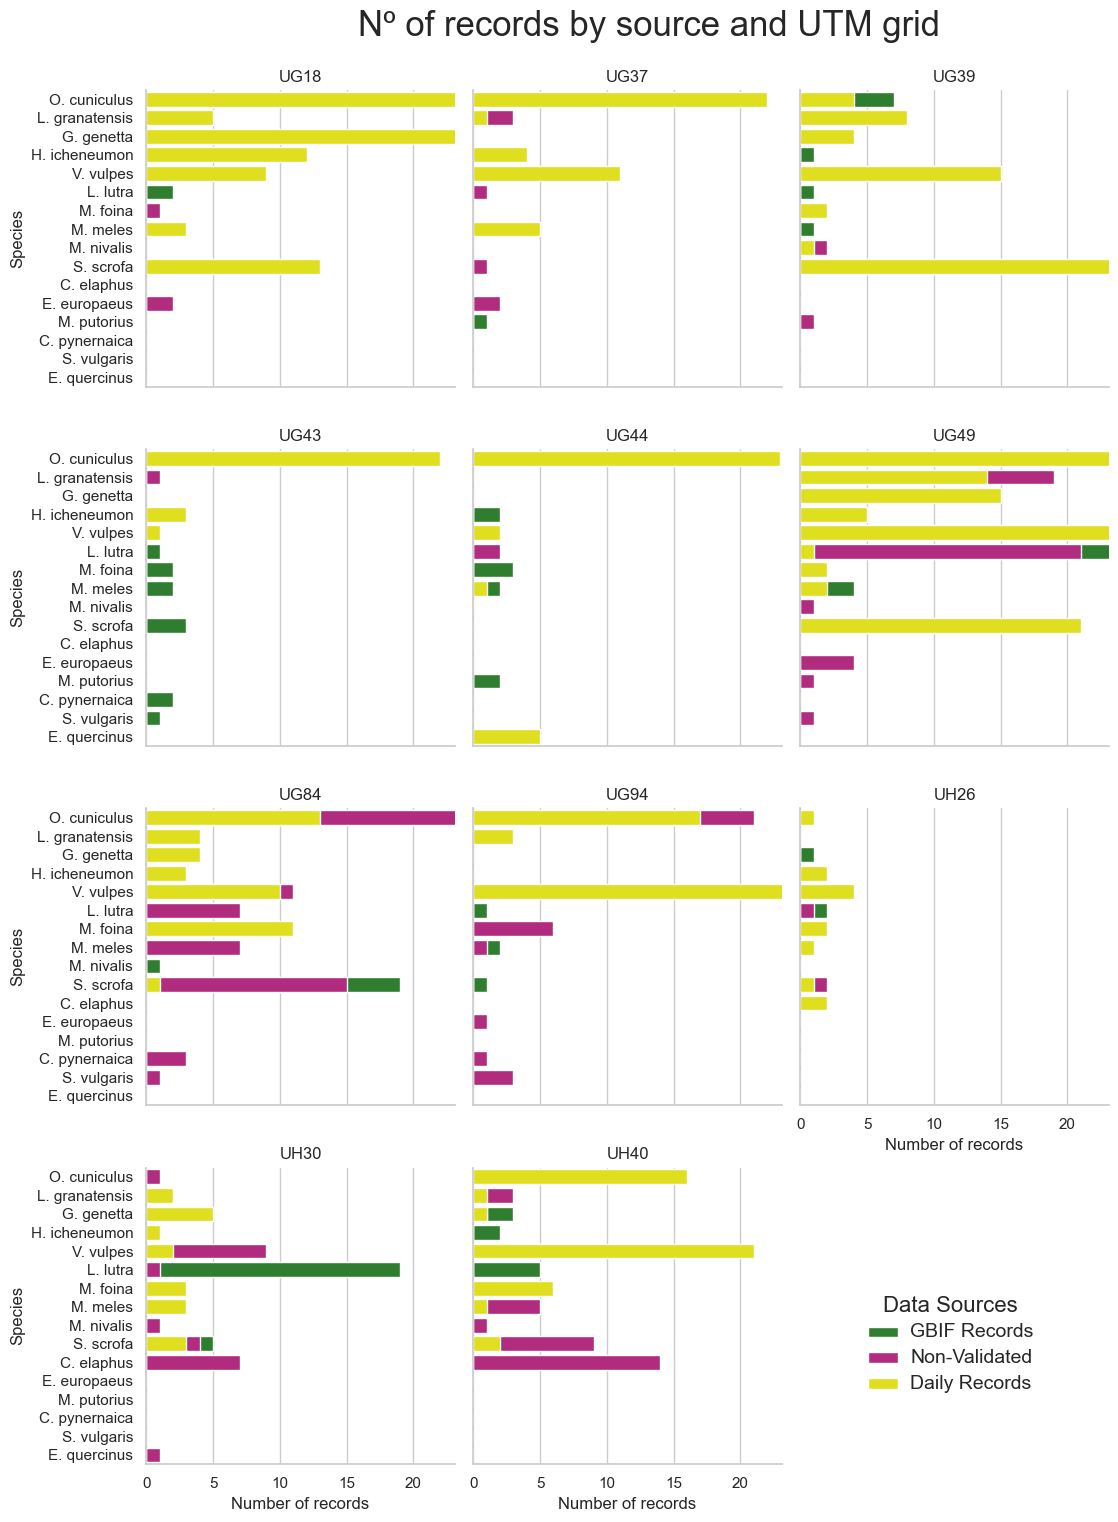

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ejemplo de datos simulados

df = pd.DataFrame(records_F1)

# Paleta corregida con hexadecimales
palette = {
    'GBIF': '#228B22',       # verde oscuro
    'NoVal': '#C71585',      # violeta rojizo
    'dailyRec': '#FFFF00'     # amarillo
}

# Crear gráfico con seaborn
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=df,
    x='Records', y='sp', hue='Platform',
    col='Grid', col_wrap=3,
    kind='bar', height=4, aspect=1,
    palette=palette,
    dodge=False  # barras apiladas
)

# Ajustar títulos y etiquetas
g.set_titles("{col_name}")
g.set_axis_labels("Number of records", "Species")
g.set(xlim=(0, None))


# Ajustar cada eje X individualmente según los datos
for ax in g.axes.flatten():
    x_max = max([patch.get_width() + patch.get_x() for patch in ax.patches])
    ax.set_xlim(0, x_max * 1.1)  # margen del 10%


# Ajustar leyenda y título general
g.figure.suptitle("Nº of records by source and UTM grid", fontsize=25, y=0.95)


# Eliminar la leyenda original
#g._legend.remove()
# Acceder a la leyenda original
legend = g._legend

legend.set_title("Data Sources")
nuevas_etiquetas = ["GBIF Records", "Non-Validated", "Daily Records"]

for text, nuevo in zip(legend.get_texts(), nuevas_etiquetas):
    text.set_text(nuevo)


# Cambiar tamaño del texto de los elementos
for text in legend.get_texts():
    text.set_fontsize(14)  # Ajusta el tamaño que desees

legend.get_title().set_fontsize(16) # Cambiar tamaño del título


legend.set_bbox_to_anchor((0.65, 0.15))  # (x, y) dentro del panel
legend._loc = 2  # 'upper left' = 2, 'upper right' = 1, etc.


# Ajustar 

plt.tight_layout()
plt.subplots_adjust(top=0.9, right=0.85)
plt.savefig("RecordsBySpecieGrid.png", dpi=300, bbox_inches='tight')
plt.show()

In [102]:
# NEGATIVE BINOMIAL MIXED MODELS
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Supongamos que tienes el DataFrame data_long1
data_long1 = pd.DataFrame(records_F1)

# Variables: Records (respuesta), Platform (factor), spp y Grid (efectos aleatorios)

# Modelo reducido (solo interceptos aleatorios)
model_reduced1 = smf.mixedlm("Records ~ 1", data_long1, groups=data_long1["spp"],
                             re_formula="~Grid").fit(method='lbfgs')

# Modelo completo con Platform
model1 = smf.mixedlm("Records ~ Platform", data_long1, groups=data_long1["spp"],
                     re_formula="~Grid").fit(method='lbfgs')

print(model1.summary())

f:\Jformacion\25_DataScienceAI\CSproject\venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning:

Random effects covariance is singular

f:\Jformacion\25_DataScienceAI\CSproject\venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.

f:\Jformacion\25_DataScienceAI\CSproject\venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning:

Random effects covariance is singular



                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       Records   
No. Observations:         528           Method:                   REML      
No. Groups:               16            Scale:                    42.9907   
Min. group size:          33            Log-Likelihood:           -1799.5871
Max. group size:          33            Converged:                Yes       
Mean group size:          33.0                                              
----------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         1.048    8.889  0.118 0.906 -16.375 18.470
Platform[T.NoVal]                -0.460    0.699 -0.658 0.510  -1.830  0.910
Platform[T.dailyRec]              0.574    0.699  0.821 0.412  -0.796  1.944
Group Var          

f:\Jformacion\25_DataScienceAI\CSproject\venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



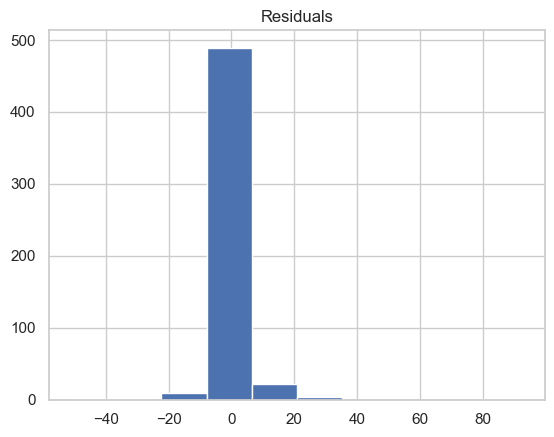

In [ ]:

# diagnosticos del modelo
import matplotlib.pyplot as plt
residuals = model1.resid
plt.hist(residuals)
plt.title("Residuals")
plt.show()


In [ ]:

# Efectos fijos
params = model1.params
print(params)

# Backtransformación (log link → exponencial)
import numpy as np
backtransformed = np.exp(params)
print("Backtransformed effects:", backtransformed)


#graficar
import seaborn as sns
sns.barplot(x=params.index, y=backtransformed)
plt.title("Backtransformed Effects")
plt.show()

